## Data Mining ECS607U Week 08 Lab: 
# Outlier Detection

## Introduction

The purpose of this lab session is to provide you with an opportunity to gain experience in **outlier detection** using common Python libraries.

- This lab is the second part of a **two-week assignment** that covers weeks 7 and 8, i.e., **assignment 3**.  <font color = 'maroon'>The last section of this notebook includes the questions that are assessed towards your final grade.</font> 


## 1. Outlier detection using parametric methods 

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g. a Gaussian distribution. Outliers can then be detected by seeking for observations that do not fit the overall distribution of the data. 

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data **stocks.csv** (available in the lab supplementary material) contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). 

In [1]:
import pandas as pd

# Load CSV file, set the 'Date' values as the index of each row, and display the first rows of the dataframe
stocks = pd.read_csv('stocks.csv', header='infer') 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [2]:
import numpy as np

N,d = stocks.shape
# Compute delta, which denotes the percentage of changes in the daily closing price of each stock
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


We can now plot the distribution of the percentage daily changes in stock price as a 3-dimensional scatter plot:

In [13]:
print(delta['F'])

Date
1/4/2007      2.529960
1/5/2007     -1.038961
1/8/2007      1.443570
1/9/2007      0.776197
1/10/2007    -0.770218
                ...   
12/23/2016    0.483871
12/27/2016   -0.561798
12/28/2016   -1.129944
12/29/2016   -0.163265
12/30/2016   -0.817661
Name: F, Length: 2517, dtype: float64


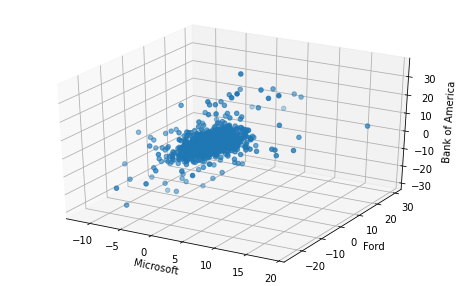

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

Let's assume that the data follows a multivariate (i.e. multidimensional) Gaussian distribution. Such a probability distribution can be characterised by two statistics: the mean and covariance matrix of the 3-dimensional data. 

We can then compute the mean and covariance matrix of the 3-dimensional 'delta' data (which represent the percentage of changes in the daily closing price of each stock). Then, as a distance measure, to determine the anomalous trading days, we can compute the **Mahalanobis distance** between the percentage of price change on each day against the mean percentage of price change:
\begin{equation}
\textrm{MDist}(x,\bar{x}) = (x - \bar{x})^T S^{-1}(x - \bar{x})
\end{equation}
where $x$ is assumed to be a row vector, $\bar{x}$ denotes the mean vector, and $S$ denotes the covariance matrix of the data.

See Section 12.3 in the "Data Mining: Concepts and Techniques" book for more information on the Mahalanobis distance. As a first step, we can define a function for the Mahalanobis distance:

In [4]:
from numpy.linalg import inv

def mahalanobis(x=None, data=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    """
    x_mu = x - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.matmul(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

Then, we can call the created function for the Mahalanobis distance on the 'delta' dataframe containing the daily percentage changes for each stock:

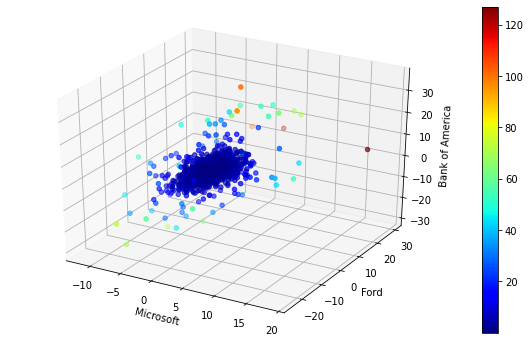

In [5]:
# Compute Mahalanobis distance for delta dataset
mahal = mahalanobis(x=delta, data=delta[['MSFT', 'F', 'BAC']])

# Assign an outlier score for the data based on the computed Mahalanobis distance
outlier_score = mahal

# Display 3D scatterplot with datapoints having a different color according to their outlier score
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The top outliers are shown as the dark red and orange points in the above scatterplot. We can examine the dates associated with the top-5 highest outlier scores as follows:

In [6]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,126.992257
11/26/2008,2.501251,29.518072,4.256757,121.360808
4/9/2009,2.501297,7.341772,35.269122,100.466343
11/28/2008,-1.317721,25.116279,5.314323,98.117362
1/21/2009,4.870124,-1.877934,30.980392,95.630501


We see for example that the top outlier was detected for 13th October 2008. This was a period of economic instability due to the 2008 global financial crisis (https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008).

We can subsequently inspect stocks around the top-2 outlier dates for each company, and see to which compani(es) are these outliers attributed to.

Text(0, 0.5, 'Percent Change')

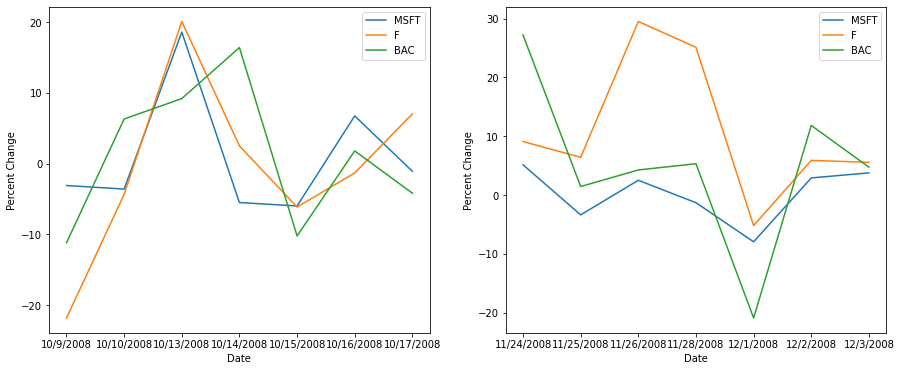

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[445:452]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[477:484]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 2. Outlier detection using proximity-based approaches

This is a model-free outlier detection approach as it does not require constructing an explicit model of the normal class to determine the outlier score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate the outlier score. Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbour whereas an outlier is likely to have a large distance to its k-th nearest neighbour. In the example below, we apply the distance-based approach with k=4 to identify the anomalous trading days from the stock market data described in the previous section.

For more information on the NearestNeighbors() function please see the scikit learn documnetation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

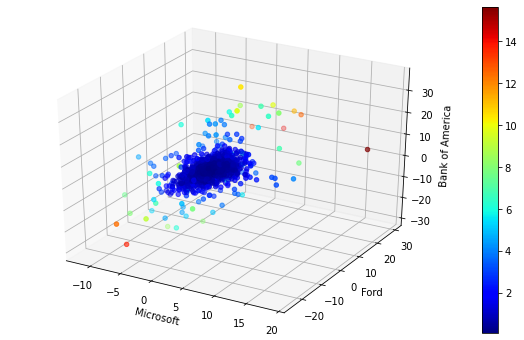

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

# Implement a k-nearest neighbour approach using k=4 neighbours
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values)
distances, indices = nbrs.kneighbors(delta.values)

# The outlier score is set as the distance between the point and its k-th nearest neighbour
outlier_score = distances[:,knn-1]

# Plot 3D scatterplot of outlier scores
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The results are slightly different than the one shown in Section 1 due to the difference distance used (Euclidean distance vs Mahalanobis distance) and the proximity criterion to detect the outliers. 

We can examine the dates associated with the top-5 highest outlier scores as follows. 

In [9]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,15.642827
11/26/2008,2.501251,29.518072,4.256757,14.212749
10/7/2008,-6.744279,-20.867209,-26.225949,13.751302
11/28/2008,-1.317721,25.116279,5.314323,13.139586
9/30/2008,6.717317,24.700240,15.702479,12.599739


Finally, similarly to what was carried out in Section 1, we can inspect stocks around those outlier dates for each company. The below figure inspects the delta values for each company around the date of the 3rd detected outlier, on 7th October 2008, which represents a key date for the 2008 financial resession with large drops in stock values. Two companies seem to be primarily responsible for the creation of this outlier.

Text(0, 0.5, 'Percent Change')

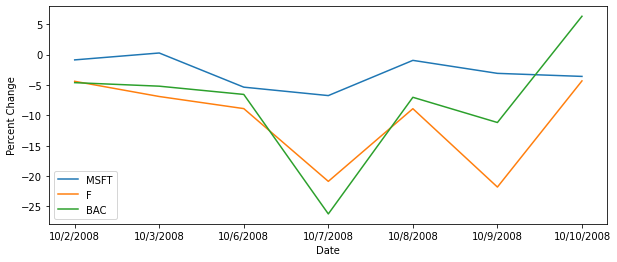

In [10]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[440:447]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 3.0 Outlier detection using classification-based methods

The **support vector machine (SVM)** algorithm developed initially for binary classification can be used for one-class classification, and therefore for outlier detection using a classification-based method where we construct a classifier to describe only the normal class.

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as **One-Class SVM**.

In this section, we will work with a different dataset on house prices available at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv . This dataset has 13 input variables that describe the properties of the house and suburb and requires the prediction of the median value of houses in the suburb in thousands of dollars. Information and metadata about the dataset can be found at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.names . Please spend some time to inspect the dataset and its metadata.

As a first step, we load the dataset and split it into input and output (target) elements:

In [ ]:
from pandas import read_csv

# Loading the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)

# Extracting the values from the dataframe
data = df.values

# Split dataset into input and output elements
X, y = data[:, :-1], data[:, -1]

# Summarize the shape of the dataset
print(X.shape, y.shape)

Using the OneClassSVM() function in scikit-learn, we can initialise and train an one-class SVM classifier on the input data. Please study the [OneClassSVM() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) for information on input arguments. 

We can then print the estimated labels, which for each object are -1 for outliers and 1 for inliers (i.e. data points that are considered normal).

In [ ]:
from sklearn.svm import OneClassSVM

ee = OneClassSVM(nu=0.01,gamma='auto')
yhat = ee.fit_predict(X) # Perform fit on input data and returns labels for that input data.

print(yhat) # Print labels: -1 for outliers and 1 for inliers.

Having trained the one-class SVM, we can then select all rows from the dataset that are **not** outliers:

In [ ]:
# Select all rows that are not outliers
mask = yhat != -1
X, y = X[mask, :], y[mask]

# Summarize the shape of the updated dataset
print(X.shape, y.shape)

As we see, the new dataset has a significantly smaller number of objects, all of which are considered by the one-class SVM to be `inliers', i.e. to belong to the normal distribution of the data.

## Assignment 3, part 2/2

For your answers to the assignment, please include include your workings (e.g. equations, code) when this is relevant to the question. Questions 1-2 are pen-and paper exercises. Question 3 can be addressed either on paper or using code. Questions 4-6 are coding exercises.

1. For an application on credit card fraud detection, we are interested in detecting contextual outliers. Suggest 2 possible contextual attributes and 2 possible behavioural attributes that could be used for this application, and explain why each of your suggested attribute should be considered as either contextual or behavioural. [0.5 marks out of 5]

2. Assume that you are provided with the [University of Wisconsin breast cancer dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data) from the Week 3 lab, and that you are asked to detect outliers from this dataset. Additional information on the dataset attributes can be found [online](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names). Explain one possible outlier detection method that you could apply for detecting outliers for this particular dataset, explain what is defined as an outlier for your suggested approach given this particular dataset, and justify why would you choose this particular method for outlier detection. [1 mark out of 5]

3. The monthly rainfall in the London borough of Tower Hamlets in 2018 had the following rainfall amount (measured in mm, values from January-December 2018): {22.93, 20.59, 25.65, 23.74, 25.24, 4.55, 23.45, 28.18, 23.52, 22.32, 26.73, 23.42}. Assuming that the data is based on a normal distribution, identify outlier values in the above dataset using the maximum likelihood method. [1 mark out of 5]

4. You are provided with the graduation rate dataset used in the Week 4 lab (file graduation_rate.csv in the Week 4 lab supplementary data). For the 'high school gpa' attribute, compute the relative frequency (i.e. frequency normalised by the size of the dataset) of each value. Show these computed relative frequencies in your report. Two new data points are included in the dataset, one with a 'high school gpa' value of 3.6, and one with a 'high school gpa' value of 2.8. Which of the two new data points is an outlier and why? [0.5 marks out of 5]

5. Using the stock prices dataset used in sections 1 and 2, estimate the outliers in the dataset using the one-class SVM classifier approach. As input to the classifier, use the percentage of changes in the daily closing price of each stock, as was done in section 1 of the notebook. Plot a 3D scatterplot of the dataset, where each object is color-coded according to whether it is an outlier or an inlier. Also compute a histogram and the frequencies of the estimated outlier and inlier labels. In terms of the plotted results, how does the one-class SVM approach for outlier detection differ from the parametric and proximity-based methods used in the lab notebook? What percentage of the dataset objects are classified as outliers? [1 mark out of 5]

6. This question will combine concepts from both data preprocessing and outlier detection. Using the house prices dataset from Section 3 of this lab notebook, perform dimensionality reduction on the dataset using PCA with 2 principal components (make sure that the dataset is z-score normalised beforehand). Then, perform outlier detection on the pre-processed dataset using the k-nearest neighbours approach using k=2. Display a scatterplot of the two principal components, where each object is colour-coded according to the computed outlier score. [1 marks out of 5]

## Q4

In [1]:
import pandas as pd

df = pd.read_csv('graduation_rate.csv')

print('Dataset (head and tail):')
display(df)

print('\nParental levels of education:')
print(df['parental level of education'].unique())

Dataset (head and tail):


,ACT composite score,SAT total score,parental level of education,parental income,high school gpa,college gpa,years to graduate
0,30,2206,master's degree,94873,4.0,3.8,3
1,26,1953,some college,42767,3.6,2.7,9
2,28,2115,some high school,46316,4.0,3.3,5
3,33,2110,some high school,52370,4.0,3.5,4
4,30,2168,bachelor's degree,92665,4.0,3.6,4
...,...,...,...,...,...,...,...
995,30,1967,high school,49002,3.8,3.5,6
996,28,2066,some college,83438,3.9,3.5,4
997,27,1971,high school,68577,3.6,3.7,5
998,30,2057,some college,56876,3.8,3.6,3



Parental levels of education:
["master's degree" 'some college' 'some high school' "bachelor's degree"
 "associate's degree" 'high school']


In [5]:
scores = df['high school gpa']
scores.value_counts(normalize=True)

4.0    0.294
3.8    0.132
3.9    0.108
3.7    0.106
3.6    0.101
3.5    0.071
3.4    0.064
3.3    0.052
3.2    0.025
3.0    0.020
3.1    0.015
2.9    0.008
2.7    0.003
2.8    0.001
Name: high school gpa, dtype: float64

## Q5

In [95]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto', nu=0.085).fit(delta)
outlier_binary = clf.predict(delta)
outlier_indeces = np.where(outlier_binary == -1)[0]
print(delta.iloc[outlier_indeces].shape)

(316, 3)


In [75]:
delta.shape

(2517, 3)

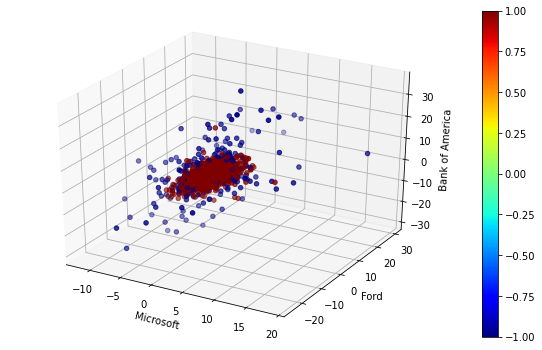

In [76]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_binary,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

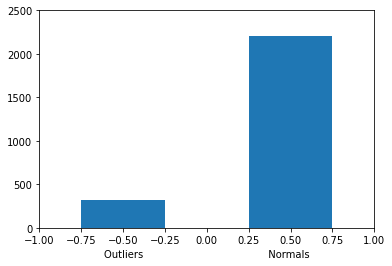

In [94]:
from matplotlib.pyplot import hist
plt.hist(outlier_binary, 2, rwidth=0.5)
plt.axis([-1,1,0,2500])
plt.xlabel('Outliers                                        Normals')
plt.show()

In [102]:
outliers = np.where(outlier_binary == -1)[0]
normal = np.where(outlier_binary == 1)[0]
print('number of outliers: ', len(outliers))
print('number of normals: ', len(normal))

number of outliers:  316
number of normals:  2201
